In [7]:
pip install gym==0.10

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
0 0.37178948521614075 0
20 0.0072961002588272095 3
40 0.005759230349212885 19
60 0.004814178682863712 35
80 0.0021610246039927006 54
100 0.004915974102914333 74
120 0.006020988803356886 94
140 0.005146747455000877 114
160 0.006307211704552174 134
180 0.0038865210954099894 154
200 0.0044713267125189304 174
220 0.0030829370953142643 194
240 0.002251892816275358 214
260 0.0031787706539034843 234
280 0.0035964595153927803 254
300 0.0019055352313444018 274
320 0.002670855261385441 294
340 0.003002185607329011 314
360 0.003131093457341194 334
380 0.002071403432637453 354
400 0.0027143729384988546 374
420 0.004300989210605621 394
440 0.006727899890393019 414
460 0.002849731594324112 434
480 0.002091288333758712 454
500 0.0022161141969263554 474
520 0.002695336239412427 494
540 0.0023309187963604927 514
560 0.003984916489571333 534
580 0.0011463406262919307 554
600 0.002462210599333048 574
620 0.

Text(0, 0.5, 'action number')

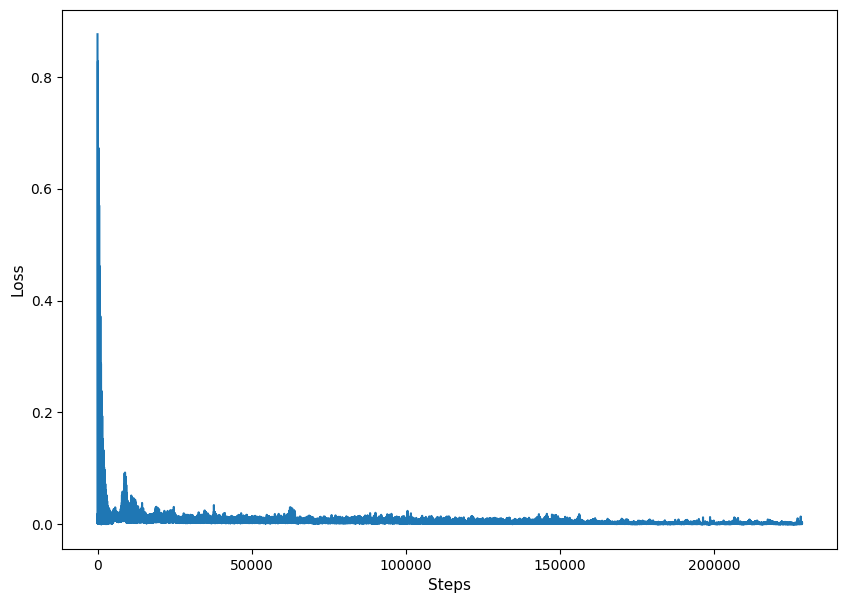

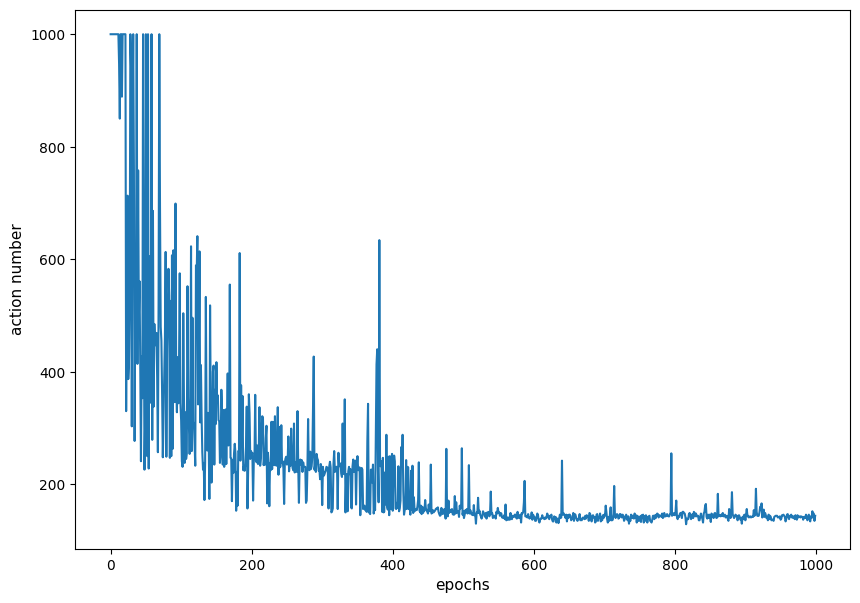

In [13]:
import copy
from sre_constants import SUCCESS
import numpy as np
import torch
import random
from matplotlib import pylab as plt
import gym
#from gym import wrappers 
from IPython.display import clear_output

L1 = 2
L2 = 150
L3 = 100
L4 = 3
model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3),
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4)
)

model2 = copy.deepcopy(model) #target network
model2.load_state_dict(model.state_dict()) #將原始Q網路中的參數複製給目標網路
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.6

env = gym.envs.make('MountainCar-v0')
env = env.unwrapped
#env = wrappers.Monitor(env,"C:\testml\video",video_callable=lambda count:count%10==0)
#env.Monitor.start('C:\testml\video',video_callable=lambda count: count % 10 == 0)

from collections import deque
epochs = 1000 #訓練次數
losses = []
step_num = []
mem_size = 1000 
batch_size = 64 #batch_size
replay = deque(maxlen=mem_size) #replay buffer
max_moves = 1000 #每場遊戲最多可以走幾步
sync_freq = 200
success_flag=0
success_num=0
j=0
for i in range(epochs):
    state1_ = env.reset()
    state1 = torch.from_numpy(state1_).float()
    status = 1
    success_flag=0
    mov = 0     #記錄移動的步數
    while(status == 1): 
        j += 1
        mov += 1
        qval = model(state1) #輸出各動作的Q值
        #print(qval,i)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,2)
        else:
            action_ = np.argmax(qval_)
        state2_, reward , done , info= env.step(action_)
        #env.render() 
        #print(state2_)
        """
        if reward != -1:
            #step_num.append(mov)
            success_flag=1
            success_num+=1
            reward=200
        """

        if mov == 700 :
            reward = reward -  0.5
        if state2_[0] >= -0.4 :
            reward +=  0.2 + state2_[0]
        if state2_[1] >= 0.02 :
            reward +=   0.2 + state2_[1]*10

        if state2_[0] > 0.5 and success_flag == 0:
            status = 0
            #reward += 20
            success_num+=1
            step_num.append(mov)
            success_flag=1
        
        #if state2_[0] > 0.5:
                #reward = 5
        #elif state2_[0] <= -0.6:
            #reward = -1 + state2_[0]
        state2 = torch.from_numpy(state2_).float()
        #print(i)
        exp = (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2 
        #print(state1)
        #print(len(replay),batch_size)     

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch_ = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch_ = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            state1_batch = torch.reshape(state1_batch_, (64, 2))
            state2_batch = torch.reshape(state2_batch_, (64, 2))

            Q1 = model(state1_batch) 
            with torch.no_grad():     
                Q2 = model2(state2_batch) 
            Y = reward_batch + gamma * torch.max(Q2,dim=1)[0]
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
            losses.append(loss.item())    

            if j % sync_freq == 0:
                model2.load_state_dict(model.state_dict())
            
        if reward == 200 or mov > max_moves:
            status = 0 
            mov = 0
        #losses.append(loss.item())  
    if epsilon > 0.001: 
        epsilon -= (1/epochs) 
    """if i % 100 == 0:
        if i!=0 and i%1000 == 0 :
            print(i,loss)
        else:
            print(i)"""
    if success_flag == 0:
        step_num.append(1000)
    if i%20 == 0:
      print(i, loss.item(),success_num)
    #print('\r')
    #print(i, loss.item(),success_num)
    #print('\r\b')
#env.close()
#test_model(model)
print(i, loss.item(),success_num)
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("Loss",fontsize=11)

plt.figure(figsize=(10,7))
plt.plot(step_num)
plt.xlabel("epochs",fontsize=11)
plt.ylabel("action number",fontsize=11)




In [ ]:
"""def test_model(model):
  i = 0
  env = gym.envs.make('MountainCar-v0')
  env = env.unwrapped
  for i in range(10):
    state3_ = env.reset()  
    env.render()
    state3 = torch.from_numpy(state3_).float()
    status = 1
    mov = 0
    while(status == 1):    
      mov += 1
      qval = model(state3)
      qval_ = qval.data.numpy()
      action_ = np.argmax(qval_) 
      print(action_)
      observation, reward, done, info = env.step(action_)
      state3=torch.from_numpy(observation).float()
      #print(action_,reward,done)
      #print(observation)
      env.render()
      if mov >= 1000:
        status=0
      #time.sleep(0.02)
      #env.render()    
    print(i)
  env.close()"""

In [12]:

#env = gym.envs.make('MountainCar-v0')
#env = env.unwrapped
test_s=0
for i in range(1000):
    state3_ = env.reset()  
    #env.render()
    state3 = torch.from_numpy(state3_).float()
    status = 1
    mov = 0 
    while(status == 1):    
        mov += 1
        qval = model(state3)
        qval_ = qval.data.numpy()
        """if (random.random() < 0.1):
            action_ = np.random.randint(0,2)
        else:
            action_ = np.argmax(qval_)"""
        action_ = np.argmax(qval_)
        #state2_, reward , done , info= env.step(action_)
        #action_ = np.argmax(qval_) 
        #print(action_)
        observation, reward, done, info = env.step(action_)
        state3=torch.from_numpy(observation).float()
        #print(action_,reward,done)
        #print(observation)
        #env.render()
        if observation[0] > 0.5 :
            status = 0
            test_s += 1
        if mov >= 1000:
            status=0
        
        #env.render()    
    #print(i)
print(test_s)
#env.close()

1000


In [ ]:
#test_model(model)